In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from tqdm.notebook import tqdm
from google.colab import drive
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class FlowerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        class_dirs = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])

        for idx, class_dir in enumerate(class_dirs):
            class_name = class_dir.name
            self.classes.append(class_name)
            self.class_to_idx[class_name] = idx

            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                for img_path in class_dir.glob(ext):
                    self.samples.append((str(img_path), idx))

        print(f"Found {len(self.samples)} images across {len(self.classes)} classes")
        for class_name in self.classes:
            class_count = sum(1 for _, label in self.samples if label == self.class_to_idx[class_name])
            print(f"  {class_name}: {class_count} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


def create_train_val_test_splits(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.samples):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)

    train_indices = []
    val_indices = []
    test_indices = []

    for class_label, indices in class_indices.items():
        train_val_idx, test_idx = train_test_split(
            indices,
            test_size=test_ratio,
            random_state=random_state
        )
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=val_ratio/(train_ratio + val_ratio),
            random_state=random_state
        )

        train_indices.extend(train_idx)
        val_indices.extend(val_idx)
        test_indices.extend(test_idx)

        class_name = dataset.classes[class_label]
        print(f"{class_name}: {len(train_idx)} train, {len(val_idx)} val, {len(test_idx)} test")

    return train_indices, val_indices, test_indices

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Flower_CNN/archive/train'

print(f"Using data directory: {DATA_DIR}")

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = FlowerDataset(DATA_DIR, transform=None)

print("\nCreating train/val/test splits...")
train_indices, val_indices, test_indices = create_train_val_test_splits(
    full_dataset,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

full_dataset_train = FlowerDataset(DATA_DIR, transform=train_transform)
full_dataset_val = FlowerDataset(DATA_DIR, transform=test_transform)
full_dataset_test = FlowerDataset(DATA_DIR, transform=test_transform)
s
train_dataset = Subset(full_dataset_train, train_indices)
val_dataset = Subset(full_dataset_val, val_indices)
test_dataset = Subset(full_dataset_test, test_indices)

train_dataset.classes = full_dataset.classes
val_dataset.classes = full_dataset.classes
test_dataset.classes = full_dataset.classes

print(f"\nFinal split sizes:")
print(f"  Training: {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Test: {len(test_dataset)} images")

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nData loaders created with batch size: {BATCH_SIZE}")

Using data directory: /content/drive/MyDrive/Flower_CNN/archive/train
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images

Creating train/val/test splits...
daisy: 350 train, 75 val, 76 test
dandelion: 452 train, 97 val, 97 test
rose: 347 train, 75 val, 75 test
sunflower: 345 train, 75 val, 75 test
tulip: 424 train, 91 val, 92 test
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images

Final split sizes:
  Training: 1918 images
  Validation: 413 images
  Test: 415 images

Data loaders created with batch size: 32


In [ ]:
class VGG16(nn.Module):
    """
    VGG-D (16 layers) implementation following the paper

    Architecture:
    - Input: 224×224×3 RGB image
    - 13 Conv layers (3×3 filters, padding=1)
    - 5 MaxPool layers (2×2, stride=2)
    - 3 FC layers (4096→4096→num_classes)
    - ReLU activations
    - Dropout (0.5) in first two FC layers
    """

    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            #Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        #Classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

num_classes = len(full_dataset.classes)
model = VGG16(num_classes=num_classes).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: VGG-16")
print(f"Number of classes: {num_classes}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model: VGG-16
Number of classes: 5
Total parameters: 134,281,029
Trainable parameters: 134,281,029


In [ ]:
CONFIG = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.01,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'lr_scheduler_patience': 5,
    'lr_scheduler_factor': 0.1
}

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    momentum=CONFIG['momentum'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=CONFIG['lr_scheduler_factor'],
    patience=CONFIG['lr_scheduler_patience'],
)

print("Training configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Training configuration:
  batch_size: 32
  num_epochs: 50
  learning_rate: 0.01
  momentum: 0.9
  weight_decay: 0.0005
  lr_scheduler_patience: 5
  lr_scheduler_factor: 0.1


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss/len(train_loader):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss/len(val_loader):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
import json

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print("Starting training...\n")

for epoch in range(CONFIG['num_epochs']):
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 60)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vgg16_model.pth')
        print(f"✅ New best model saved! (Val Acc: {val_acc:.2f}%)")

    print("\n")

print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

Starting training...

Epoch 1/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.5466 | Train Acc: 28.47%
Val Loss: 1.4174 | Val Acc: 39.71%
✅ New best model saved! (Val Acc: 39.71%)


Epoch 2/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.3771 | Train Acc: 38.22%
Val Loss: 1.3106 | Val Acc: 39.95%
✅ New best model saved! (Val Acc: 39.95%)


Epoch 3/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.3336 | Train Acc: 39.99%
Val Loss: 1.3010 | Val Acc: 44.55%
✅ New best model saved! (Val Acc: 44.55%)


Epoch 4/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.3289 | Train Acc: 40.93%
Val Loss: 1.3366 | Val Acc: 41.89%


Epoch 5/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.2957 | Train Acc: 42.23%
Val Loss: 1.2020 | Val Acc: 50.12%
✅ New best model saved! (Val Acc: 50.12%)


Epoch 6/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.2603 | Train Acc: 45.20%
Val Loss: 1.1937 | Val Acc: 46.73%


Epoch 7/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.2227 | Train Acc: 48.23%
Val Loss: 1.1210 | Val Acc: 47.46%


Epoch 8/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.1816 | Train Acc: 49.22%
Val Loss: 1.2122 | Val Acc: 52.78%
✅ New best model saved! (Val Acc: 52.78%)


Epoch 9/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.1417 | Train Acc: 51.98%
Val Loss: 1.0459 | Val Acc: 53.51%
✅ New best model saved! (Val Acc: 53.51%)


Epoch 10/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.1422 | Train Acc: 50.26%
Val Loss: 1.0868 | Val Acc: 52.78%


Epoch 11/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.1527 | Train Acc: 52.76%
Val Loss: 1.1060 | Val Acc: 52.78%


Epoch 12/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.1119 | Train Acc: 53.34%
Val Loss: 1.0636 | Val Acc: 57.14%
✅ New best model saved! (Val Acc: 57.14%)


Epoch 13/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.0400 | Train Acc: 58.03%
Val Loss: 0.9392 | Val Acc: 60.77%
✅ New best model saved! (Val Acc: 60.77%)


Epoch 14/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.0428 | Train Acc: 57.77%
Val Loss: 0.9592 | Val Acc: 61.02%
✅ New best model saved! (Val Acc: 61.02%)


Epoch 15/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.9772 | Train Acc: 61.84%
Val Loss: 0.9941 | Val Acc: 60.77%


Epoch 16/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 1.0211 | Train Acc: 59.59%
Val Loss: 0.9810 | Val Acc: 61.26%
✅ New best model saved! (Val Acc: 61.26%)


Epoch 17/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.9749 | Train Acc: 61.68%
Val Loss: 0.9996 | Val Acc: 55.69%


Epoch 18/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.9335 | Train Acc: 63.09%
Val Loss: 0.8517 | Val Acc: 64.16%
✅ New best model saved! (Val Acc: 64.16%)


Epoch 19/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.8751 | Train Acc: 66.68%
Val Loss: 0.8802 | Val Acc: 65.62%
✅ New best model saved! (Val Acc: 65.62%)


Epoch 20/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.9068 | Train Acc: 65.64%
Val Loss: 0.9006 | Val Acc: 66.59%
✅ New best model saved! (Val Acc: 66.59%)


Epoch 21/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.8128 | Train Acc: 69.08%
Val Loss: 0.8122 | Val Acc: 68.04%
✅ New best model saved! (Val Acc: 68.04%)


Epoch 22/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.8118 | Train Acc: 69.76%
Val Loss: 0.8023 | Val Acc: 68.77%
✅ New best model saved! (Val Acc: 68.77%)


Epoch 23/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.8540 | Train Acc: 67.47%
Val Loss: 1.0228 | Val Acc: 59.56%


Epoch 24/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.8248 | Train Acc: 67.05%
Val Loss: 0.8320 | Val Acc: 68.04%


Epoch 25/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7973 | Train Acc: 69.81%
Val Loss: 0.9397 | Val Acc: 66.83%


Epoch 26/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7980 | Train Acc: 69.03%
Val Loss: 0.8294 | Val Acc: 66.83%


Epoch 27/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7594 | Train Acc: 72.05%
Val Loss: 0.8233 | Val Acc: 69.73%
✅ New best model saved! (Val Acc: 69.73%)


Epoch 28/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7372 | Train Acc: 71.69%
Val Loss: 0.8415 | Val Acc: 67.07%


Epoch 29/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7568 | Train Acc: 71.85%
Val Loss: 0.9115 | Val Acc: 64.65%


Epoch 30/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7607 | Train Acc: 71.79%
Val Loss: 0.7901 | Val Acc: 69.49%


Epoch 31/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7030 | Train Acc: 73.36%
Val Loss: 0.7972 | Val Acc: 67.31%


Epoch 32/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.6879 | Train Acc: 73.41%
Val Loss: 0.8396 | Val Acc: 68.04%


Epoch 33/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.7075 | Train Acc: 73.83%
Val Loss: 0.9012 | Val Acc: 66.83%


Epoch 34/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.6017 | Train Acc: 77.32%
Val Loss: 0.7211 | Val Acc: 74.58%
✅ New best model saved! (Val Acc: 74.58%)


Epoch 35/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5495 | Train Acc: 78.73%
Val Loss: 0.7076 | Val Acc: 73.85%


Epoch 36/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5451 | Train Acc: 79.41%
Val Loss: 0.7034 | Val Acc: 74.33%


Epoch 37/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5439 | Train Acc: 79.67%
Val Loss: 0.6988 | Val Acc: 76.03%
✅ New best model saved! (Val Acc: 76.03%)


Epoch 38/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5273 | Train Acc: 79.77%
Val Loss: 0.7153 | Val Acc: 75.06%


Epoch 39/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5324 | Train Acc: 79.35%
Val Loss: 0.7025 | Val Acc: 75.06%


Epoch 40/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4996 | Train Acc: 80.81%
Val Loss: 0.7071 | Val Acc: 74.09%


Epoch 41/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5026 | Train Acc: 81.80%
Val Loss: 0.7209 | Val Acc: 73.37%


Epoch 42/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5011 | Train Acc: 80.92%
Val Loss: 0.7087 | Val Acc: 75.30%


Epoch 43/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.5004 | Train Acc: 80.81%
Val Loss: 0.7237 | Val Acc: 75.06%


Epoch 44/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4892 | Train Acc: 81.65%
Val Loss: 0.7095 | Val Acc: 74.82%


Epoch 45/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4684 | Train Acc: 82.12%
Val Loss: 0.7038 | Val Acc: 75.06%


Epoch 46/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4876 | Train Acc: 81.54%
Val Loss: 0.7031 | Val Acc: 75.30%


Epoch 47/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4798 | Train Acc: 82.27%
Val Loss: 0.7031 | Val Acc: 75.79%


Epoch 48/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4683 | Train Acc: 82.01%
Val Loss: 0.7022 | Val Acc: 75.79%


Epoch 49/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4934 | Train Acc: 82.22%
Val Loss: 0.7043 | Val Acc: 75.54%


Epoch 50/50
------------------------------------------------------------


Training:   0%|          | 0/60 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Train Loss: 0.4766 | Train Acc: 81.75%
Val Loss: 0.7041 | Val Acc: 75.79%


Training completed! Best validation accuracy: 76.03%


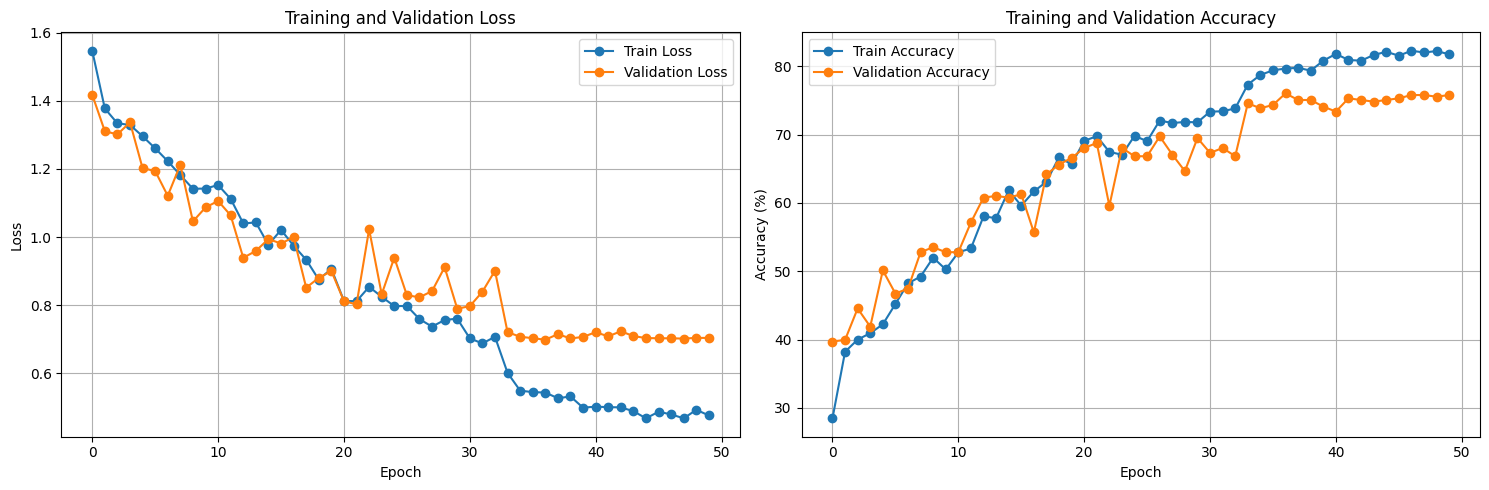

Best validation accuracy: 76.03%


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Best validation accuracy: {best_val_acc:.2f}%")

In [ ]:
model.load_state_dict(torch.load('best_vgg16_model.pth'))
model.eval()

def evaluate_test_set(model, test_loader, device, with_flip=False):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)

            if with_flip:
                outputs1 = model(images)
                outputs2 = model(torch.flip(images, [3]))
                outputs = (outputs1 + outputs2) / 2
            else:
                outputs = model(images)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

print("Testing without horizontal flip...")
acc_no_flip, preds_no_flip, labels_no_flip = evaluate_test_set(model, test_loader, device, with_flip=False)
print(f"Test Accuracy (no flip): {acc_no_flip:.2f}%\n")

print("Testing with horizontal flip...")
acc_with_flip, preds_with_flip, labels_with_flip = evaluate_test_set(model, test_loader, device, with_flip=True)
print(f"Test Accuracy (with flip): {acc_with_flip:.2f}%")
print(f"Improvement from flipping: +{acc_with_flip - acc_no_flip:.2f}%")

Testing without horizontal flip...


Testing:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy (no flip): 73.25%

Testing with horizontal flip...


Testing:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy (with flip): 73.01%
Improvement from flipping: +-0.24%


In [ ]:
def multi_scale_test(model, test_dataset, device, scales=[256, 384, 512]):
    model.eval()
    all_outputs = []

    for scale in scales:
        print(f"Testing at scale {scale}...")

        transform = transforms.Compose([
            transforms.Resize(scale),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        temp_dataset = FlowerDataset(DATA_DIR, transform=transform)
        temp_subset = Subset(temp_dataset, test_indices)
        temp_loader = DataLoader(temp_subset, batch_size=32, shuffle=False, num_workers=2)

        scale_outputs = []
        with torch.no_grad():
            for images, _ in tqdm(temp_loader, desc=f'Scale {scale}'):
                images = images.to(device)
                outputs = model(images)
                scale_outputs.append(outputs.cpu())

        all_outputs.append(torch.cat(scale_outputs, dim=0))

    avg_outputs = torch.stack(all_outputs).mean(dim=0)
    _, predictions = avg_outputs.max(1)

    true_labels = [test_dataset.dataset.samples[idx][1] for idx in test_dataset.indices]

    correct = (predictions.numpy() == np.array(true_labels)).sum()
    accuracy = 100. * correct / len(true_labels)

    return accuracy

print("\nMulti-scale testing...")
multi_scale_acc = multi_scale_test(model, test_dataset, device, scales=[256, 384, 512])
print(f"\nMulti-scale Test Accuracy: {multi_scale_acc:.2f}%")
print(f"Improvement from multi-scale: +{multi_scale_acc - acc_with_flip:.2f}%")


Multi-scale testing...
Testing at scale 256...
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images


Scale 256:   0%|          | 0/13 [00:00<?, ?it/s]

Testing at scale 384...
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images


Scale 384:   0%|          | 0/13 [00:00<?, ?it/s]

Testing at scale 512...
Found 2746 images across 5 classes
  daisy: 501 images
  dandelion: 646 images
  rose: 497 images
  sunflower: 495 images
  tulip: 607 images


Scale 512:   0%|          | 0/13 [00:00<?, ?it/s]


Multi-scale Test Accuracy: 69.40%
Improvement from multi-scale: +-3.61%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nPer-class Performance:")
print("="*60)
print(classification_report(labels_with_flip, preds_with_flip,
                           target_names=test_dataset.classes))

cm = confusion_matrix(labels_with_flip, preds_with_flip)
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100

print("\nPer-class Accuracy:")
for class_name, acc in zip(test_dataset.classes, per_class_acc):
    print(f"  {class_name}: {acc:.2f}%")


Per-class Performance:
              precision    recall  f1-score   support

       daisy       0.81      0.78      0.79        76
   dandelion       0.79      0.81      0.80        97
        rose       0.61      0.63      0.62        75
   sunflower       0.71      0.87      0.78        75
       tulip       0.73      0.58      0.64        92

    accuracy                           0.73       415
   macro avg       0.73      0.73      0.73       415
weighted avg       0.73      0.73      0.73       415


Per-class Accuracy:
  daisy: 77.63%
  dandelion: 81.44%
  rose: 62.67%
  sunflower: 86.67%
  tulip: 57.61%


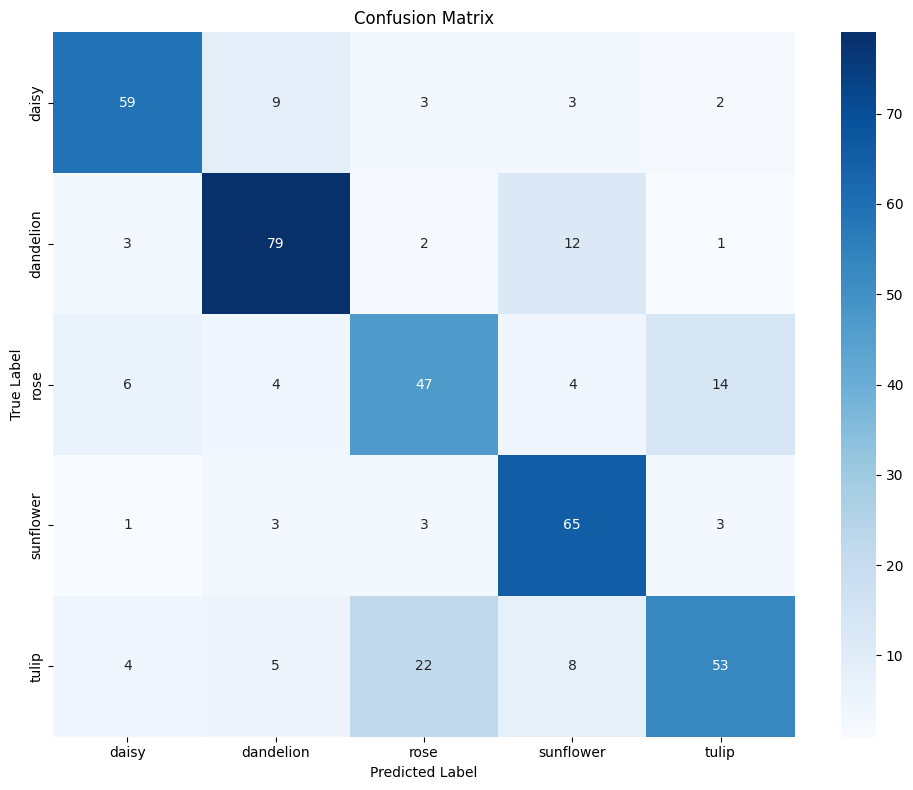

In [ ]:
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(labels_with_flip, preds_with_flip, test_dataset.classes)